In [1]:
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import shutil

physical_devices = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", physical_devices, len(tf.config.list_physical_devices('GPU')))
# tf.test.gpu_device_name()
device_lib.list_local_devices()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


batch_size = 8
epochs = 5
lr_rate = 1e-3
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (224, 224, 3)


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 1
1 Physical GPUs, 1 Logical GPUs


data sort

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers


initial_lr = 1e-3 # learning rate
# epochs = 40 # no of eopches to train
# batch_size = 32 # batch size 
img_size = 224

print("LOADING IMAGES.......")
imagePaths = list(paths.list_images("data"))
data = []
labels =[]


#loop for the image paths
for imagePath in imagePaths:
	#extract the class label from the file
	label = imagePath.split(os.path.sep)[-2]

	#load the image
	#swap color channels and resize it
	#fixed 224*224 pixels while ingorning aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (img_size, img_size))

	#update the data and labes lists
	data.append(image)
	labels.append(label)

print("original labels: ", labels[0])
print("original labels: ", labels[-1])
# print("original labels to binary: ",labels)

#convert the data and labels to numpay
#while scalling the pixel to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)


# performs one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

print("original labels to binary: ",labels[0])
print("original labels to binary: ",labels[-1])
# print("original labels to binary: ",labels)

# labels = to_categorical(labels)
# print("binary labels to category: ", labels[0])
# print("binary labels to category: ", labels[-1])
# print("binary labels to category: ", labels)

#partition the data for tranning(80%)
#and testing(20%) using splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

data_generator_with_aug = ImageDataGenerator(
#  rotation_range=45,
#  fill_mode="nearest", 
#  horizontal_flip=True, 
 width_shift_range = 0.1, 
 height_shift_range = 0.1, 
#  shear_range=16
)


# data_generator_with_aug = ImageDataGenerator()




# print(testX)
# data_generator_with_aug.fit(trainX)
# print(plt.imshow(trainX[0]))
# print(lb.classes_)

LOADING IMAGES.......
original labels:  covideff
original labels:  normaleff
original labels to binary:  [0]
original labels to binary:  [1]


function for creating, fitting the model and plot the result

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_model(baseModel):
    baseModel.trainable=False  # all base weight set to non-trainable
    #constructing the head of the model that will be placed
    #on the top of the model
    headModel = baseModel.output
    headModel = layers.GlobalAveragePooling2D()(headModel)
    # headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.2)(headModel)
    # headModel = Dense(1, activation="sigmoid")(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    #place the head FC model on top of the base model
    #it will become the actual model will be train
    model = Model(inputs=baseModel.input, outputs=headModel)
    # #loop over all layers in the base model 
    # for layer in baseModel.layers:
    # 	layer.trainable = False
    #compile our model
    print("compiling model.....")
    opt = Adam(learning_rate=initial_lr, decay=initial_lr / epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=["accuracy"])
    return model

def fit_model(model,model_filepath):
    checkpoint = ModelCheckpoint(
                filepath=model_filepath,
                monitor = 'val_accuracy',
                mode='max',
                save_best_only=True,
                verbose=1
                )
    history = model.fit(
            trainX, trainY,
            batch_size=batch_size,
            steps_per_epoch=len(trainX) // batch_size,
            epochs=epochs,
            validation_data=(testX, testY),
            validation_steps=len(testX) // batch_size,
            callbacks=[checkpoint]
            )
    return history

# def plot_history(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']

#     loss=history.history['loss']
#     val_loss=history.history['val_loss']

#     epochs_range = range(epochs)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, acc, label='Training Accuracy')
#     plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#     plt.legend(loc='lower right')
#     plt.title('Training and Validation Accuracy')

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, loss, label='Training Loss')
#     plt.plot(epochs_range, val_loss, label='Validation Loss')
#     plt.legend(loc='upper right')
#     plt.title('Training and Validation Loss')
#     plt.show()

In [8]:
base_model1 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model2 = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

model1 = create_model(base_model1)
model2 = create_model(base_model2)

model_saved_folder_path = 'model_saved\\'
model_weight_path = 'weight\\'

model_filepath1 = model_saved_folder_path + model_weight_path + "model-InceptionV3-{epoch:02d}-{val_accuracy:.4f}.h5"
model_filepath2 = model_saved_folder_path + model_weight_path + "model-VGG16-{epoch:02d}-{val_accuracy:.4f}.h5"



compiling model.....
compiling model.....


In [12]:
model1.summary()
model2.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [5]:


#train the head of the network
print("tranning head.........")
history1 = fit_model(model1, model_filepath1)
history2 = fit_model(model2, model_filepath2)

tranning head.........
Epoch 1/5
200/200 [==============================] - 13s 29ms/step - loss: 0.5942 - accuracy: 0.7812 - val_loss: 0.4755 - val_accuracy: 0.7625

Epoch 00001: val_accuracy improved from -inf to 0.76250, saving model to model_saved\weight\model-InceptionV3-01-0.7625.h5
Epoch 2/5
200/200 [==============================] - 5s 24ms/step - loss: 0.3090 - accuracy: 0.8712 - val_loss: 0.2759 - val_accuracy: 0.8875

Epoch 00002: val_accuracy improved from 0.76250 to 0.88750, saving model to model_saved\weight\model-InceptionV3-02-0.8875.h5
Epoch 3/5
200/200 [==============================] - 5s 24ms/step - loss: 0.2776 - accuracy: 0.8737 - val_loss: 0.2833 - val_accuracy: 0.8825

Epoch 00003: val_accuracy did not improve from 0.88750
Epoch 4/5
200/200 [==============================] - 5s 24ms/step - loss: 0.2618 - accuracy: 0.8969 - val_loss: 0.2771 - val_accuracy: 0.8825

Epoch 00004: val_accuracy did not improve from 0.88750
Epoch 5/5
200/200 [==========================

In [ ]:
plot_history(history1)
plot_history(history2)

In [5]:
def load_all_models(model_path_name):
    all_models = []
    # model_path_name = []
    model_names = model_path_name
    for model_name in model_names:
        filename = os.path.join(model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

In [6]:
from tensorflow.keras import layers
def ensemble_model(models):
        # model1.summary()

    # models[0].layers[0]._name = models[0].layers[0]._name + "inc"
    # models[1].layers[0]._name = models[1].layers[0]._name + "inc"

    for i, layer in enumerate(models[0].layers):
        layer._name = models[0].layers[i]._name + "_inc"
    for i, layer in enumerate(models[1].layers):
        layer._name = models[1].layers[i]._name + "_vgg"


    for i, model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False
            from tensorflow.keras import layers

    ensemble_visible = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    merge = tf.keras.layers.Dense(10, activation='relu')(merge)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(merge)
    model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])
    return model

In [9]:
model_used = ['InceptionV3', 'VGG16']
model_best_acc = ['-02-0.8875','-05-0.9100']

model_weight_loaded1 =  model_saved_folder_path + model_weight_path + 'model-' + model_used[0] + model_best_acc[0] + '.h5'
model_weight_loaded2 =  model_saved_folder_path + model_weight_path + 'model-' + model_used[1] + model_best_acc[1] + '.h5'
model_weight_name =[model_weight_loaded1,model_weight_loaded2]

print(model_weight_name)

models = load_all_models(model_weight_name)
# models.summary()
model = ensemble_model(models)
model.summary()

['model_saved\\weight\\model-InceptionV3-02-0.8875.h5', 'model_saved\\weight\\model-VGG16-05-0.9100.h5']
loaded: model_saved\weight\model-InceptionV3-02-0.8875.h5
loaded: model_saved\weight\model-VGG16-05-0.9100.h5
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_inc (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_inc (Conv2D)             (None, 111, 111, 32) 864         input_1_inc[0][0]                
__________________________________________________________________________________________________
batch_normalization_inc (BatchN (None, 111, 111, 32) 96          conv2d_inc[0][0]                 
___________________________________________________________________________

c:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
X = [trainX for _ in range(len(model.input))]
X_1 = [testX for _ in range(len(model.input))]

In [12]:
model_filepath = model_saved_folder_path + model_weight_path + "model-ensemble-{epoch:02d}-{val_accuracy:.4f}.h5"

checkpoint = ModelCheckpoint(
            filepath=model_filepath,
            monitor = 'val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
            )
history = model.fit(
        X, trainY,
        batch_size=batch_size,
        steps_per_epoch=len(trainX) // batch_size,
        epochs=epochs,
        validation_data=(X_1, testY),
        validation_steps=len(testX) // batch_size,
        callbacks=[checkpoint])

Epoch 1/5


c:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\backend.py:5029: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


200/200 [==============================] - 21s 61ms/step - loss: 0.5567 - accuracy: 0.7538 - val_loss: 0.5165 - val_accuracy: 0.8150

Epoch 00001: val_accuracy improved from -inf to 0.81500, saving model to model_saved\weight\model-ensemble-01-0.8150.h5
Epoch 2/5
200/200 [==============================] - 11s 53ms/step - loss: 0.4742 - accuracy: 0.8719 - val_loss: 0.4468 - val_accuracy: 0.8825

Epoch 00002: val_accuracy improved from 0.81500 to 0.88250, saving model to model_saved\weight\model-ensemble-02-0.8825.h5
Epoch 3/5
200/200 [==============================] - 11s 53ms/step - loss: 0.4028 - accuracy: 0.9106 - val_loss: 0.3778 - val_accuracy: 0.9175

Epoch 00003: val_accuracy improved from 0.88250 to 0.91750, saving model to model_saved\weight\model-ensemble-03-0.9175.h5
Epoch 4/5
200/200 [==============================] - 11s 53ms/step - loss: 0.3349 - accuracy: 0.9275 - val_loss: 0.3170 - val_accuracy: 0.9300

Epoch 00004: val_accuracy improved from 0.91750 to 0.93000, saving m

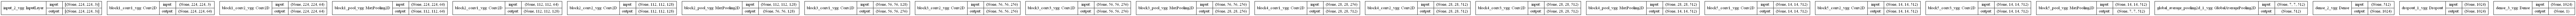

In [13]:
from tensorflow.keras.utils import plot_model
# from keras.utils import vis_utils
import os

model1 = models[0]
model2 = models[1]

summary_save_path = 'model_summary/'
### create file here need to manual create folder at window explorer

plot_model(model,to_file= summary_save_path + 'model_ensemble_plot.png' , show_shapes=True, show_layer_names=True)
plot_model(model1, to_file= summary_save_path + 'model_1_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model2, to_file= summary_save_path + 'model_2_plot.png', show_shapes=True, show_layer_names=True)

# model1.summary()
# model2.summary()
# model.summary()